In [1]:
# __author__ == shubham0704
from time import time

import cv2
import higra as hg
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_name = "../myntra_women-kurta_page_10item_0.jpg"

In [3]:
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
image = image.astype(np.float32)/255.0

In [5]:
size = image.shape[:2]

# MCG

In [11]:
class MCG:
    def __init__(self):
        self.detector = cv2.ximgproc.\
createStructuredEdgeDetection("../cache_models/structured_edges/model.yml.gz")
    
    def _build_tree(self, gradient_image, size):
        graph = hg.get_4_adjacency_graph(size)
        edge_weights = hg.weight_graph(graph, gradient_image, 
                                       hg.WeightFunction.mean)
        tree, altitudes = hg.watershed_hierarchy_by_area(graph, 
                                                         edge_weights)
        return graph, tree, altitudes
        
    def _calc_saliency(self, graph, tree, altitudes):
        saliency = hg.saliency(tree, altitudes)
        saliency_khalimsky = hg.graph_4_adjacency_2_khalimsky(graph, 
                                                              saliency)
        return saliency_khalimsky
    
    def _prepare_interaction_area(self, image, saliency_khalimsky):
        
        image_alpha = np.pad(image, ((0,0),(0,0),(0,1)), 
                             mode='constant', 
                             constant_values=1)
        sm = saliency_khalimsky**0.5
        sm = sm[1::2,1::2]
        sm = np.pad(sm, ((0,1),(0,1)), mode='edge')
        sm = 1 - sm / np.max(sm)
        sm = np.dstack([sm]*3)
        #alpha channel
        sm = np.pad(sm, ((0,0),(0,0),(0,1)), mode='constant', 
                    constant_values=1)
        # this will be the background of the user interaction 
        #area : image | saliency map
        base_image = np.hstack((image_alpha, sm))
        markers = np.zeros_like(image_alpha)
        return base_image, markers
        
    
    def run_transforms(self, image):
        gradient_image = self.detector.detectEdges(image)
        graph, tree, altitudes = self._build_tree(gradient_image, 
                                                   image.shape[:2])
        
        saliency_khalimsky = self._calc_saliency(graph, tree, altitudes)
        base_image, markers = self._prepare_interaction_area(
            image, saliency_khalimsky)
        return base_image, markers, tree
    
mcg = MCG()
base_image, markers, tree = mcg.run_transforms(image)

In [42]:
%matplotlib notebook

<IPython.core.display.Javascript object>


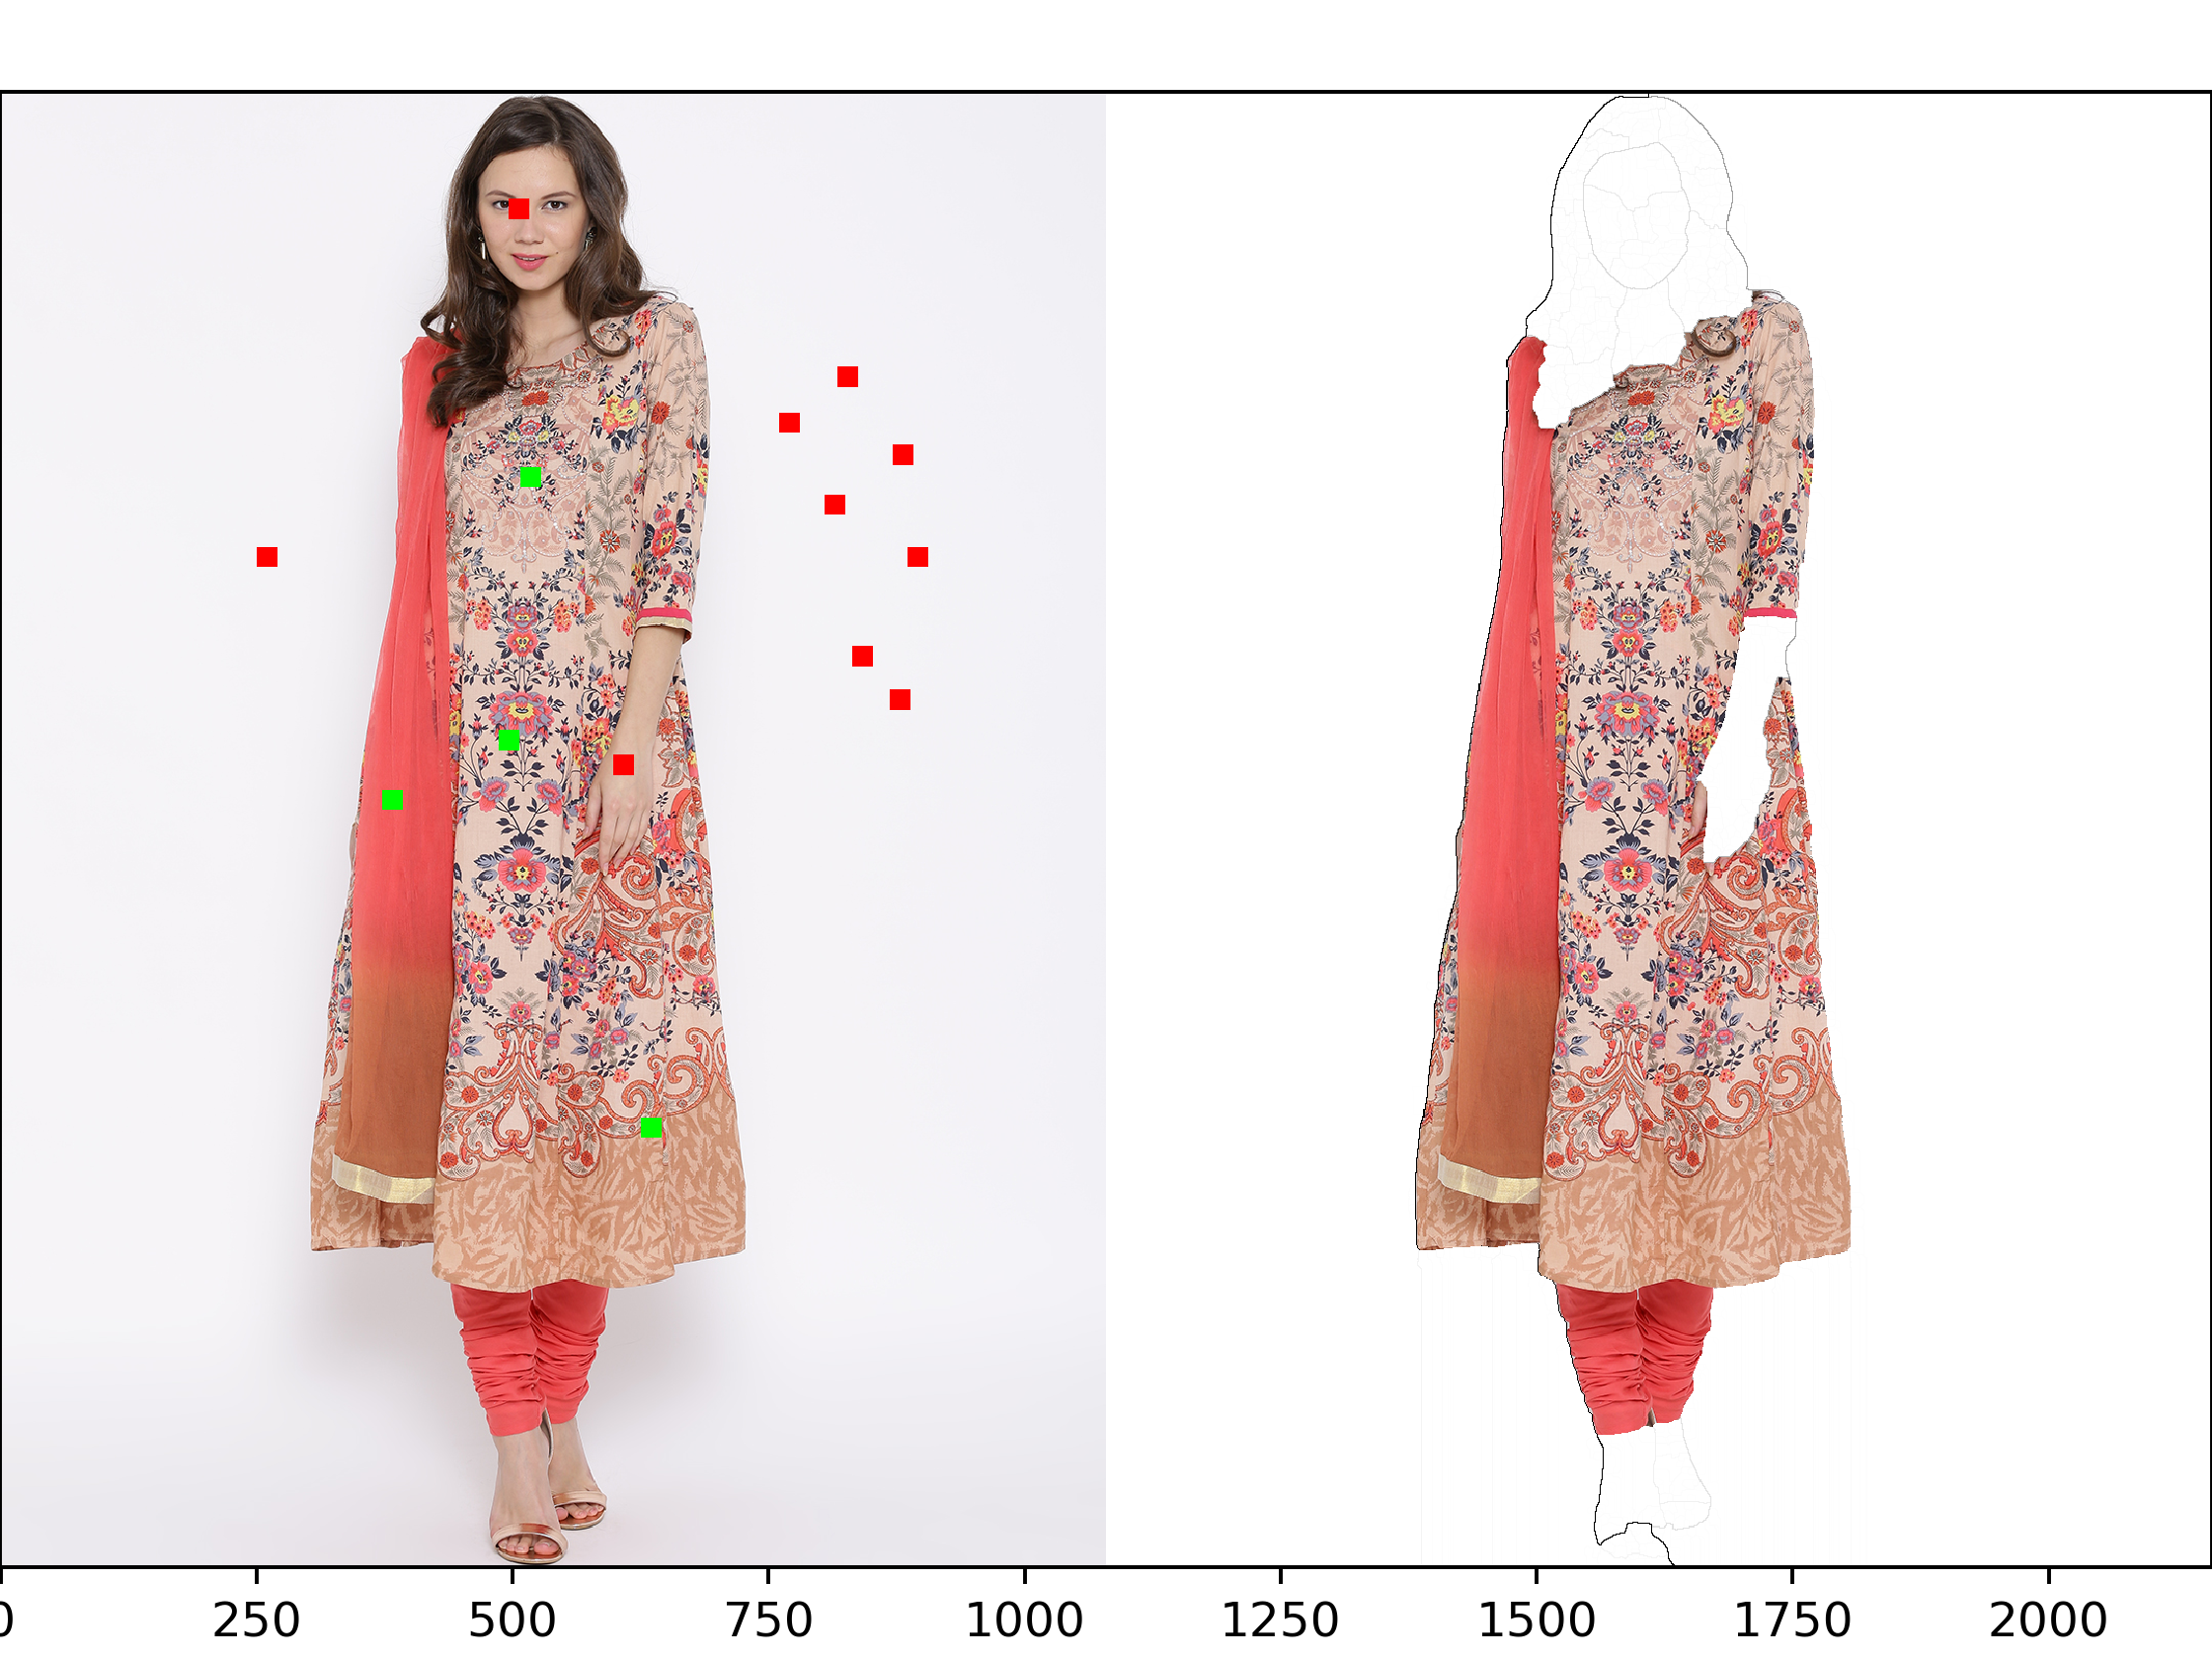

In [43]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.imshow(base_image)
plt.axis('off')
plt.show()

**Instructions**

+ ```Shift + Click``` - Foreground Label
+ ```Click``` - Background Label
+ ```a``` - Save Image

Note - Run the cell below first and then the above figure becomes interactive

In [44]:
def onclick(event):
    #remove prvious drawing
    ax.clear()
    # click position
    x = int(event.xdata) % size[1] # modulo click on the right image wraps on the first one
    y = int(event.ydata)
    
    if event.key == "shift": # left click
        markers[y-10:y+10, x-10:x+10, :]= (0,1,0,1) # green marker : object
    else:
        markers[y-10:y+10, x-10:x+10, :]= (1,0,0,1) # red marker : background
    # compute binary segmentation from the two markers
    result = hg.binary_labelisation_from_markers(tree, markers[:,:,1], markers[:,:,0])
    
    # redraw background
    ax.imshow(base_image, interpolation='none')
    
    # use the binary segmentation as the alpha channel to display the result
    tmp = np.copy(image)
    res = np.dstack((tmp,result))
    
    # show markers on left image
    op = np.hstack((markers, res))
    ax.imshow(op, interpolation='none')

# Create an hard reference to the callback not to be cleared by the garbage collector
ka = fig.canvas.mpl_connect('button_press_event', onclick)

def key_down(event):
    if event.key == "a":
        filename = "./temp.jpg"
        result = hg.binary_labelisation_from_markers(tree, markers[:,:,1], markers[:,:,0])
        cv2.imwrite(filename, result)
        print("file_saved_as:", filename)

cid = fig.canvas.mpl_connect('key_press_event', key_down)

In [37]:
img = cv2.imread('temp.jpg', cv2.IMREAD_GRAYSCALE)

In [29]:
%matplotlib inline

In [39]:
img *= 255

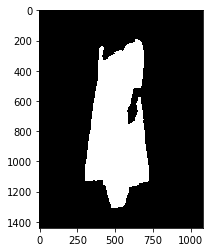

In [40]:
plt.imshow(img, cmap="gray")